# Lazy FCA classification

## Libraries

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import warnings
from sklearn.exceptions import ConvergenceWarning, FitFailedWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FitFailedWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# pd.set_option("display.max_columns", None)

## Data Preparation

### Data overview
Dataset link: https://www.kaggle.com/datasets/blastchar/telco-customer-churn

In [2]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

df = df.drop("customerID", axis=1)
print(df.shape)
df.head(10)

(7043, 20)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,Male,0,No,Yes,62,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [3]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [4]:
# Unique values of each feature
categorical_columns = df.select_dtypes(include=["object"]).columns
unique_values = {col: df[col].unique() for col in categorical_columns}
unique_values

{'gender': array(['Female', 'Male'], dtype=object),
 'Partner': array(['Yes', 'No'], dtype=object),
 'Dependents': array(['No', 'Yes'], dtype=object),
 'PhoneService': array(['No', 'Yes'], dtype=object),
 'MultipleLines': array(['No phone service', 'No', 'Yes'], dtype=object),
 'InternetService': array(['DSL', 'Fiber optic', 'No'], dtype=object),
 'OnlineSecurity': array(['No', 'Yes', 'No internet service'], dtype=object),
 'OnlineBackup': array(['Yes', 'No', 'No internet service'], dtype=object),
 'DeviceProtection': array(['No', 'Yes', 'No internet service'], dtype=object),
 'TechSupport': array(['No', 'Yes', 'No internet service'], dtype=object),
 'StreamingTV': array(['No', 'Yes', 'No internet service'], dtype=object),
 'StreamingMovies': array(['No', 'Yes', 'No internet service'], dtype=object),
 'Contract': array(['Month-to-month', 'One year', 'Two year'], dtype=object),
 'PaperlessBilling': array(['Yes', 'No'], dtype=object),
 'PaymentMethod': array(['Electronic check', 'Mailed 

Remove all values with `NaN` in `TotalCharges`, since there will still be a lot of data to classify

In [5]:
df = df.dropna(subset=["TotalCharges"])
print(df.shape)
df = df.sample(n=4000, random_state=42).reset_index(drop=True)
print(df.shape)
df.head()

(7032, 20)
(4000, 20)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Male,1,Yes,No,61,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),25.00,1501.75,No
1,Female,0,No,No,19,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Bank transfer (automatic),24.70,465.85,No
2,Male,0,Yes,No,13,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Credit card (automatic),102.25,1359.00,Yes
3,Male,0,Yes,No,37,Yes,Yes,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Mailed check,55.05,2030.75,No
4,Female,0,No,No,6,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Bank transfer (automatic),29.45,161.45,No


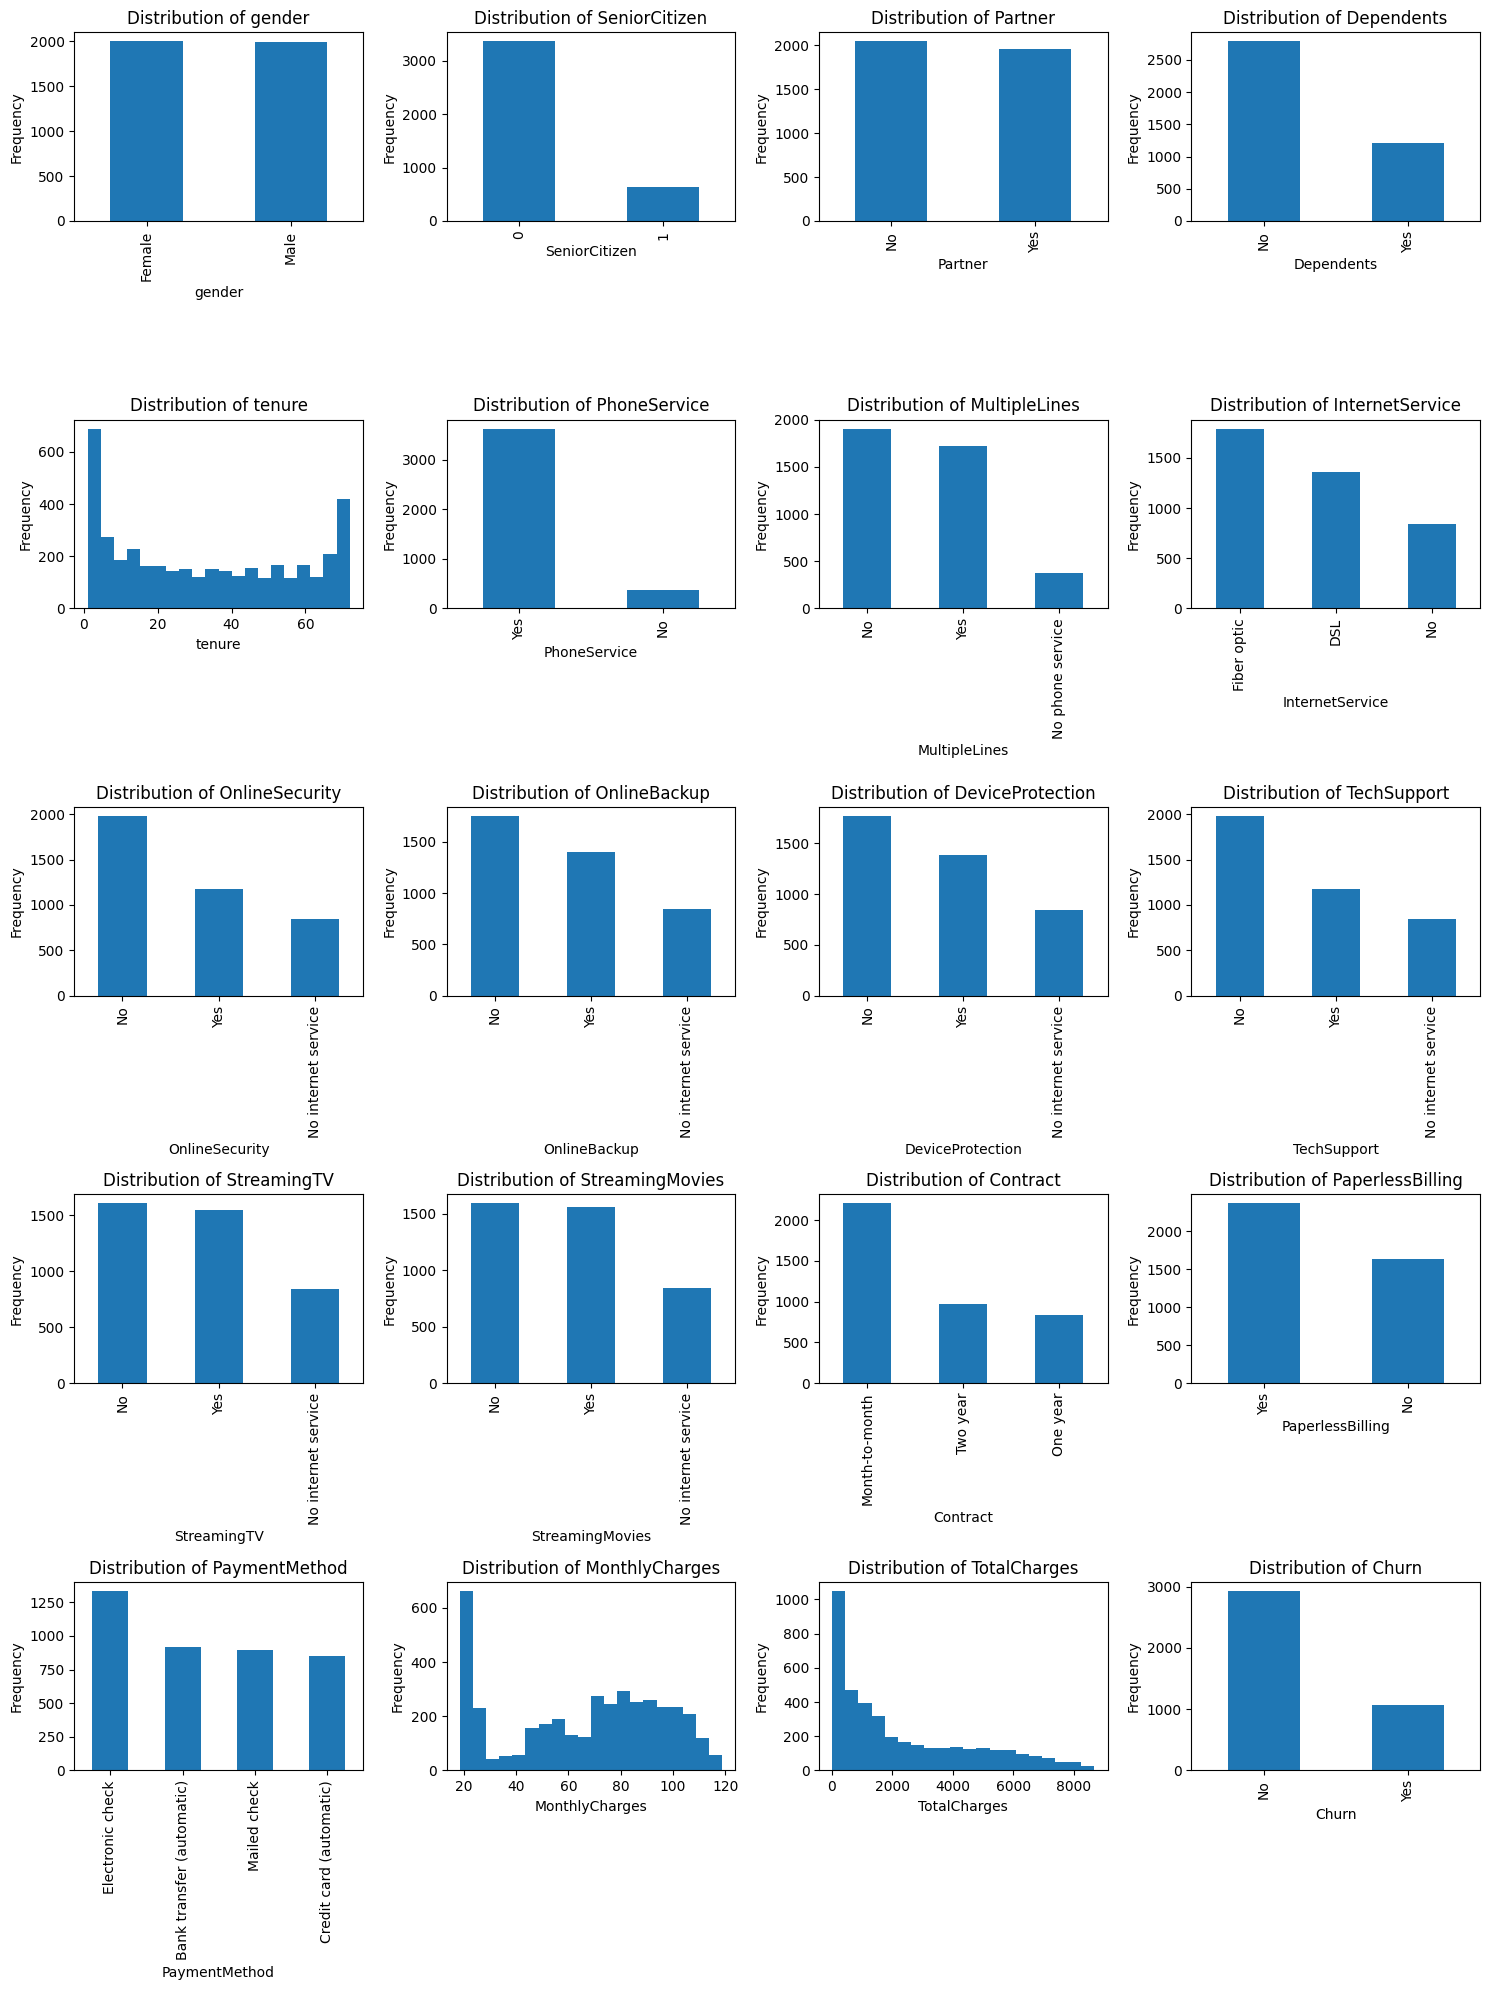

In [6]:
num_columns = len(df.columns)
cols = 4  # Number of columns in the grid (adjust as needed)
rows = math.ceil(num_columns / cols)

# Create a grid of subplots
fig, axes = plt.subplots(
    rows, cols, figsize=(15, rows * 4)
)  # Adjust figure size as needed
axes = axes.flatten()  # Flatten to easily iterate over axes

for i, column in enumerate(df.columns):
    ax = axes[i]
    if df[column].dtype == "object" or len(df[column].unique()) < 20:
        # For categorical or discrete features, use a bar plot
        df[column].value_counts().plot(kind="bar", ax=ax)
        ax.set_title(f"Distribution of {column}")
        ax.set_xlabel(column)
        ax.set_ylabel("Frequency")
    else:
        # For continuous features, use a histogram
        df[column].plot(kind="hist", bins=20, ax=ax)
        ax.set_title(f"Distribution of {column}")
        ax.set_xlabel(column)
        ax.set_ylabel("Frequency")

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust layout for readability
plt.show()

### Data binarization and analisis

#### Categorical features

- There is some features like `MultipleLines` or `OnlineSecurity`, in addition to the values `Yes` or `No`, there are values `No internet service` or `No telephone service`. I will replace them with `No`, because that values don't contain any valuable information (information about the availability of the Internet or telephone is in the columns `InternetService` and `PhoneService` respectively)
- For categorical column with `Yes` and `No` values I will use Dichotomic Scaling, for other categorical features (with many different values) Nominal scaling will be used
- Special case: `InternetService` column will be divided in four columns. The first two columns will refer to the availability of the internet service (Dichotomic Scaling) other two will represent the type of the internet (Nominal Scaling)

In [7]:
# Replace redundant properties
df.replace(["No internet service", "No phone service"], "No", inplace=True)
df["SeniorCitizen"] = df["SeniorCitizen"].map({1: "Yes", 0: "No"})

# Drop the target column
categorical_columns = df.select_dtypes(include=["object"]).columns.drop("Churn")

# Encoding with OHE
encoder = OneHotEncoder(drop=None, sparse_output=False)
encoded_features = encoder.fit_transform(df[categorical_columns])
encoded_df = pd.DataFrame(
    encoded_features, columns=encoder.get_feature_names_out(categorical_columns)
)

# Column for 'InternetService_Yes'
encoded_df["InternetService_Yes"] = df["InternetService"].apply(
    lambda x: 0.0 if x == "No" else 1.0
)
encoded_df

,gender_Female,gender_Male,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,...,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Yes
0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
4,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3996,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3997,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3998,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


When all features are numbers we can create some plots for its analisis. Here the correlation heatmap of features

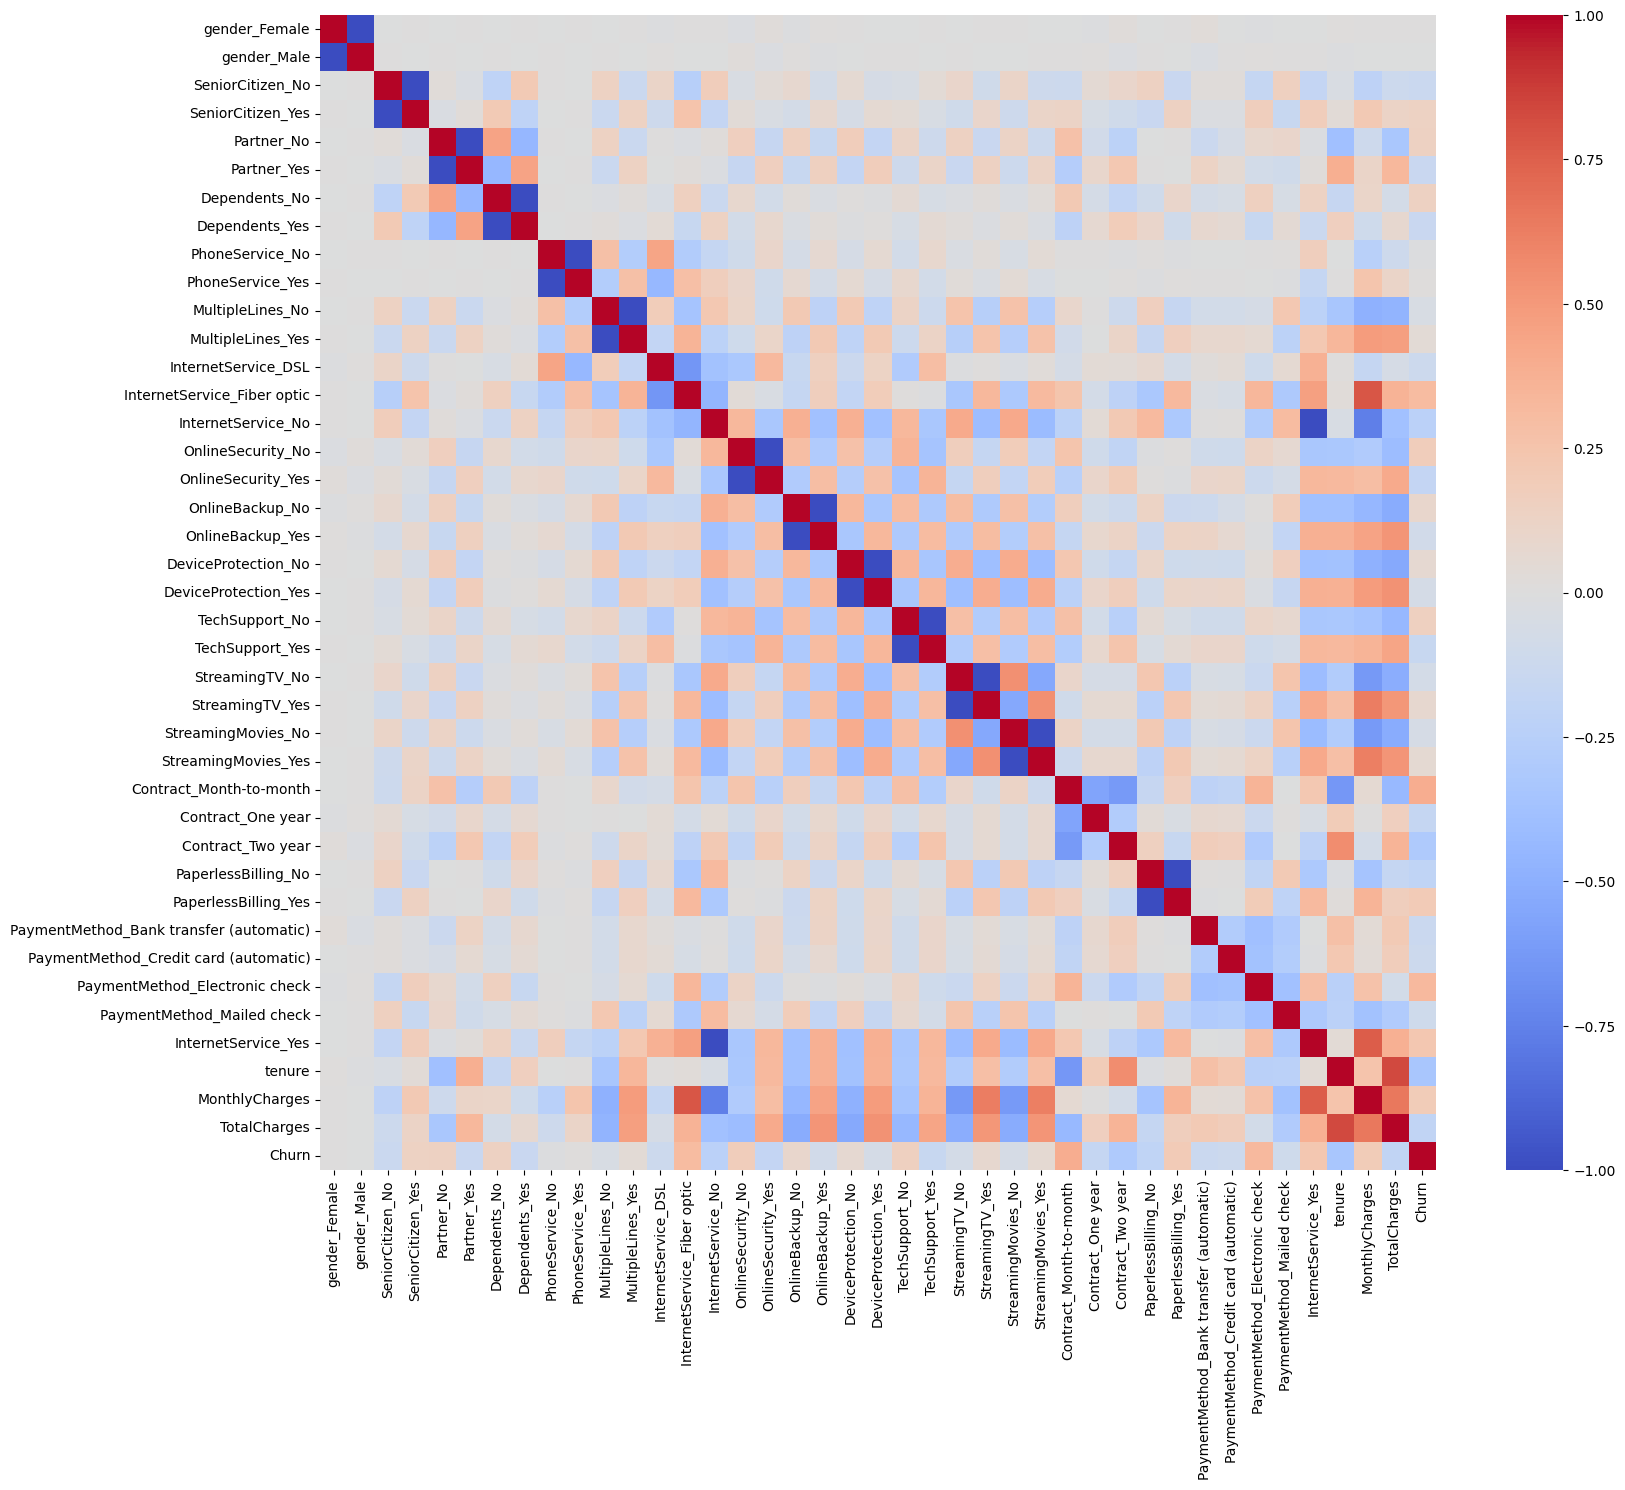

In [8]:
numeric_features = ["tenure", "MonthlyCharges", "TotalCharges"]
numeric_cols = df[numeric_features]
analis_df = pd.concat(
    [encoded_df.copy(), numeric_cols, df["Churn"].map({"Yes": 1, "No": 0})], axis=1
)
corr_matrix = analis_df.select_dtypes(include=[float, int]).corr()
plt.subplots(figsize=(18, 15))
sns.heatmap(
    corr_matrix,
    cmap=sns.color_palette("coolwarm", 10000),
    vmin=-1,
    center=0,
)
plt.show()

In [10]:
# Features with high correlation with each other
corr_pairs = np.where((np.abs(corr_matrix) >= 0.75) & (np.abs(corr_matrix) < 0.99))
corr_pairs = [
    (corr_matrix.columns[i], corr_matrix.columns[j])
    for i, j in zip(*corr_pairs)
    if i != j
]
corr_pairs

[('InternetService_Fiber optic', 'MonthlyCharges'),
 ('InternetService_No', 'MonthlyCharges'),
 ('InternetService_Yes', 'MonthlyCharges'),
 ('tenure', 'TotalCharges'),
 ('MonthlyCharges', 'InternetService_Fiber optic'),
 ('MonthlyCharges', 'InternetService_No'),
 ('MonthlyCharges', 'InternetService_Yes'),
 ('TotalCharges', 'tenure')]

In [9]:
# Correlations of the features with target
corr_with_churn = analis_df.corr()["Churn"].sort_values(ascending=False)
corr_with_churn

Churn                                      1.000000
Contract_Month-to-month                    0.391155
PaymentMethod_Electronic check             0.320639
InternetService_Fiber optic                0.306615
InternetService_Yes                        0.230663
PaperlessBilling_Yes                       0.200356
MonthlyCharges                             0.194274
OnlineSecurity_No                          0.178605
TechSupport_No                             0.153505
Dependents_No                              0.145551
Partner_No                                 0.142427
SeniorCitizen_Yes                          0.138330
OnlineBackup_No                            0.088645
StreamingTV_Yes                            0.070932
DeviceProtection_No                        0.063015
StreamingMovies_Yes                        0.056696
MultipleLines_Yes                          0.042178
PhoneService_Yes                           0.013748
gender_Female                              0.006178
gender_Male 

In [10]:
# Get all features with low correlation and drop them
corr_threshold = 0.08
irrelevant_features = corr_matrix["Churn"][
    np.abs(corr_matrix["Churn"]) < corr_threshold
].index
print(irrelevant_features)

encoded_df = encoded_df.drop(irrelevant_features, axis=1)

Index(['gender_Female', 'gender_Male', 'PhoneService_No', 'PhoneService_Yes',
       'MultipleLines_No', 'MultipleLines_Yes', 'DeviceProtection_No',
       'DeviceProtection_Yes', 'StreamingTV_No', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_Yes'],
      dtype='object')


#### Numerical features

Firstly, let visualize scaled distribution of all numerical features. And display some information about them

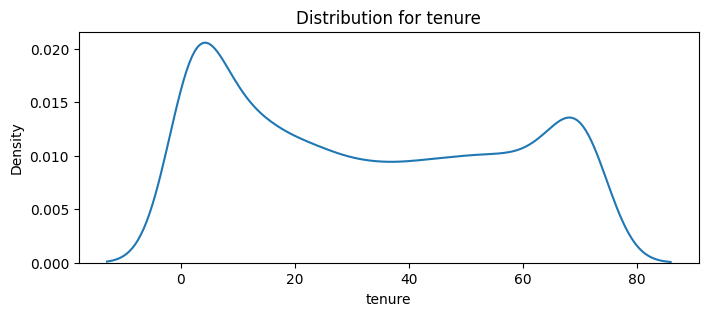

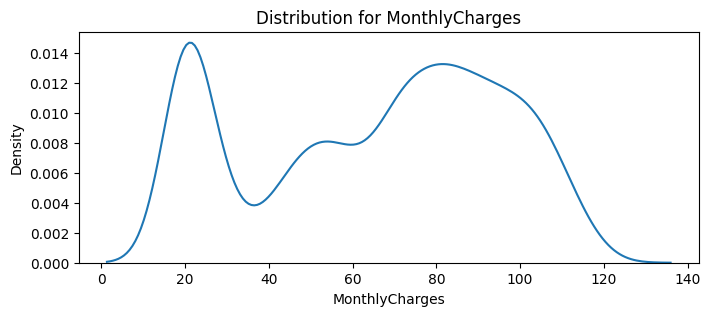

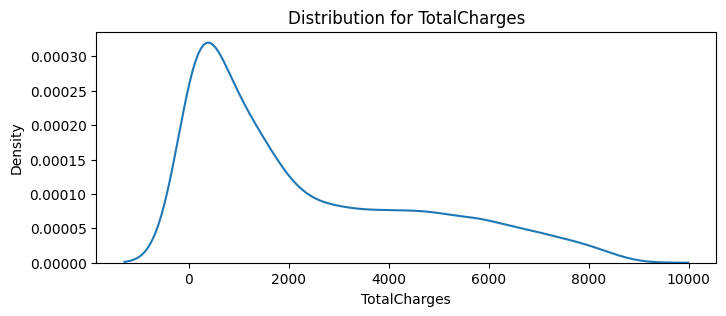

In [16]:
df_std = pd.DataFrame(
    StandardScaler().fit_transform(df[numeric_features].astype("float64")),
    columns=numeric_features,
)
for feat in numeric_features:
    plt.figure(figsize=(8, 3))
    plt.title("Distribution for {}".format(feat))
    ax = sns.kdeplot(df_std[feat])

In [17]:
df[numeric_features].describe()

,tenure,MonthlyCharges,TotalCharges
count,4000.000000,4000.000000,4000.000000
mean,32.657750,65.382513,2324.162388
std,24.478979,30.059784,2284.590424
min,1.000000,18.550000,18.800000
25%,9.000000,39.400000,416.275000
50%,30.000000,70.675000,1425.175000
75%,55.000000,90.100000,3928.862500
max,72.000000,118.750000,8684.800000


- I decided to take quantiles values of the train set to create the thresholds and then make Inter-Ordinal Scale on data
- I will take 6 quantiles (so there will be 36 new features, 12 for each numeric feature) 

In [18]:
def get_tresholds(X_num, quantile_step):
    quantile = quantile_step
    frame = pd.DataFrame()
    while quantile < 0.99:
        frame = pd.concat([frame, X_num.quantile(q=quantile)], axis=1)
        quantile += quantile_step
    return frame.T

In [19]:
X = analis_df.drop("Churn", axis=1)
y = analis_df["Churn"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
split_num = 7
quantile_step = 1 / split_num
thresh_fr = get_tresholds(X_train[numeric_features], quantile_step)
thresh_fr

,tenure,MonthlyCharges,TotalCharges
0.142857,3.0,20.55,165.20
0.285714,12.0,45.30,527.90
0.428571,23.0,64.40,1108.00
0.571429,38.0,76.95,1874.45
0.714286,52.0,87.70,3475.55
0.857143,66.0,99.80,5435.60


In [25]:
for thresholds in thresh_fr.values:
    for i in range(0, thresh_fr.columns.size):
        encoded_df[f"{thresh_fr.columns[i]}>={thresholds[i]:.2f}"] = (
            X[f"{thresh_fr.columns[i]}"] >= thresholds[i]
        )
        encoded_df[f"{thresh_fr.columns[i]}<={thresholds[i]:.2f}"] = (
            X[f"{thresh_fr.columns[i]}"] <= thresholds[i]
        )

# Replace all ones and zeros with booleans
encoded_df = encoded_df.astype(bool)
encoded_df["Churn"] = y
print(encoded_df.shape)
encoded_df.head(5)

(4000, 62)


,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,...,MonthlyCharges<=87.70,TotalCharges>=3475.55,TotalCharges<=3475.55,tenure>=66.00,tenure<=66.00,MonthlyCharges>=99.80,MonthlyCharges<=99.80,TotalCharges>=5435.60,TotalCharges<=5435.60,Churn
0,False,True,False,True,True,False,False,False,True,True,...,True,False,True,False,True,False,True,False,True,0
1,True,False,True,False,True,False,False,False,True,True,...,True,False,True,False,True,False,True,False,True,0
2,True,False,False,True,True,False,False,True,False,True,...,False,False,True,False,True,True,False,False,True,1
3,True,False,False,True,True,False,True,False,False,False,...,True,False,True,False,True,False,True,False,True,0
4,True,False,True,False,True,False,True,False,False,False,...,True,False,True,False,True,False,True,False,True,0


Make train test splut for futher classification

In [18]:
y = encoded_df["Churn"]
X = encoded_df.drop("Churn", axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

## Lazy classification algorithm

In [19]:
class LazyClassifierFCA:

    def __init__(self, as_balanced=True, default_class=0, pos_err=0, neg_err=0):
        """
        as_banced
        :param as_balanced: if True adds multipliers for numbers of negative and positive classifiers according to their balancing in train dataset
        :param default_class: default classification when positive_classifiers == negative_classifiers
        :param pos_err: the probability with which we can be wrong when classifying the intersection as positive
        :param neg_err: the probability with which we can be wrong when classifying the intersection as negative
        :return: dictionary with metrics
        """
        self.as_balanced = as_balanced
        self.default_class = default_class
        self.pos_err = pos_err
        self.neg_err = neg_err
        self.X_train = None
        self.y_train = None

    def fit(self, X_train: pd.DataFrame, y_train: pd.Series) -> None:
        self.X_train = X_train
        self.y_train = y_train

        self.balance_coef = 1
        if self.as_balanced:
            self.balance_coef = (
                self.X_train[y_train == 0].size / self.X_train[y_train == 1].size
            )

    def classify_sample(self, sample: pd.Series):
        # Split X_train into positive and negative classes
        X_train_positive = self.X_train[y_train == 1]
        X_train_negative = self.X_train[y_train == 0]
        positive_classifiers = 0
        negative_classifiers = 0

        # Function to check if intersection with a train sample is a positive classifier
        def is_positive_classifier(intersection):
            # Find samples in X_train_positive that contain the intersection
            num_positive = (
                ((X_train_positive | ~intersection) == True).all(axis=1).sum()
            )
            num_negative = (
                ((X_train_negative | ~intersection) == True).all(axis=1).sum()
            )
            if self.pos_err > 0 and num_negative > 0:
                return num_negative / (self.balance_coef * num_positive) <= self.pos_err
            return num_negative == 0 and num_positive > 1

        # Function to check if intersection is a negative classifier
        def is_negative_classifier(intersection):
            # Find samples in X_train_negative that contain the intersection
            num_positive = (
                ((X_train_positive | ~intersection) == True).all(axis=1).sum()
            )
            num_negative = (
                ((X_train_negative | ~intersection) == True).all(axis=1).sum()
            )
            if self.neg_err > 0 and num_positive > 0:
                return (self.balance_coef * num_positive) / num_negative <= self.neg_err
            return num_positive == 0 and num_negative > 1

        # Check for positive classifiers by intersecting sample with each positive object
        for _, pos_sample in X_train_positive.iterrows():
            intersection = sample & pos_sample
            if is_positive_classifier(intersection):
                positive_classifiers += 1 * self.balance_coef
        # Check for negative classifiers by intersecting sample with each negative object
        for _, neg_sample in X_train_negative.iterrows():
            intersection = sample & neg_sample
            if is_negative_classifier(intersection):
                negative_classifiers += 1
        # Determine the class based on the number of classifiers
        if positive_classifiers > negative_classifiers:
            return 1  # Predict positive
        elif negative_classifiers > positive_classifiers:
            return 0  # Predict negative
        else:
            # If equal, you can decide on a rule, like defaulting to 0 or 1, or returning 'undetermined'
            return self.default_class  # or 0, depending on the choice

    def predict(self, X_test: pd.DataFrame):
        # List to store predictions for each test sample
        predictions = []

        # Iterate through each sample in X_test
        for _, sample in X_test.iterrows():
            # Classify the sample and append the result to predictions
            prediction = self.classify_sample(sample)
            predictions.append(prediction)

        return predictions

In [20]:
# Function for confusion matrix vizualization
def confusion_plot(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

              precision    recall  f1-score   support

           0       0.75      0.96      0.84       290
           1       0.62      0.16      0.26       110

    accuracy                           0.74       400
   macro avg       0.69      0.56      0.55       400
weighted avg       0.72      0.74      0.68       400



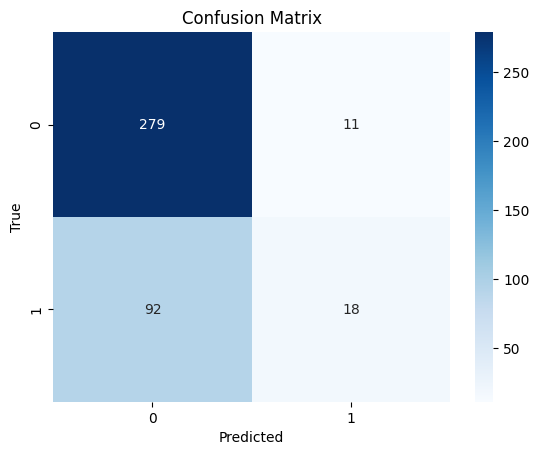

In [21]:
unb_lazy_classifier = LazyClassifierFCA(as_balanced=False)
unb_lazy_classifier.fit(X_train, y_train)
y_un_laz_pred = unb_lazy_classifier.predict(X_test)
print(classification_report(y_test, y_un_laz_pred))
confusion_plot(y_test, y_un_laz_pred)

              precision    recall  f1-score   support

           0       0.76      0.94      0.84       290
           1       0.59      0.22      0.32       110

    accuracy                           0.74       400
   macro avg       0.67      0.58      0.58       400
weighted avg       0.71      0.74      0.70       400



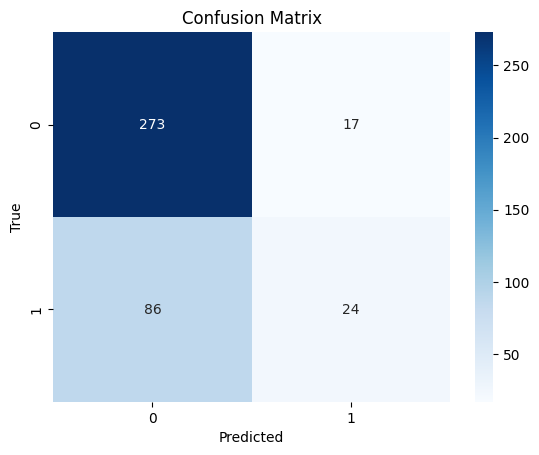

In [22]:
bln_lazy_classifier = LazyClassifierFCA(as_balanced=True)
bln_lazy_classifier.fit(X_train, y_train)
y_bl_laz_pred = bln_lazy_classifier.predict(X_test)
print(classification_report(y_test, y_bl_laz_pred))
confusion_plot(y_test, y_bl_laz_pred)

              precision    recall  f1-score   support

           0       0.84      0.82      0.83       290
           1       0.56      0.60      0.58       110

    accuracy                           0.76       400
   macro avg       0.70      0.71      0.71       400
weighted avg       0.77      0.76      0.76       400



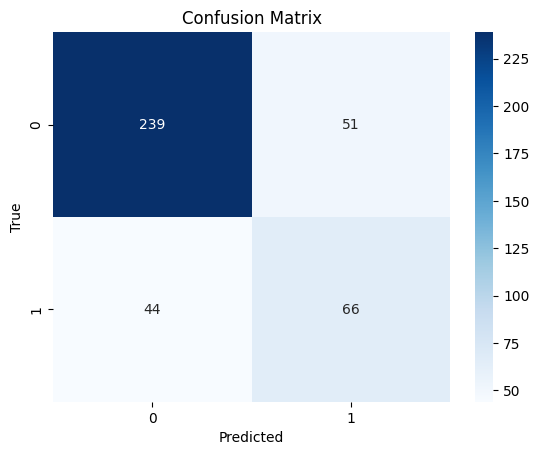

In [23]:
def1_lazy_classifier = LazyClassifierFCA(as_balanced=True, pos_err=0.1, neg_err=0)
def1_lazy_classifier.fit(X_train, y_train)
y_def1_laz_pred = def1_lazy_classifier.predict(X_test)
print(classification_report(y_test, y_def1_laz_pred))
confusion_plot(y_test, y_def1_laz_pred)

## Comparison with other models

**KNN results:** from https://www.kaggle.com/code/ozdemirh/customer-churn-prediction-with-knn-classifier

class|precision|recall|f1-score|support
|---|---|---|---|---|
Churn No | 0.85 | 0.87 | 0.86 | 1035
Churn Yes |0.61|0.57|0.59|374
accuracy  |     |     |0.79|1409
macro avg |0.73 |0.72 |0.72|1409
weighted avg |0.78|0.79|0.79|1409

### Data preprocessing for other models

All code here are copied from this notebook https://www.kaggle.com/code/ebrahimmerza/customer-churn-classification-ml-logre-xgboost#XGBoost

In [24]:
service_columns = [
    "PhoneService",
    "MultipleLines",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "PaperlessBilling",
]
df.replace("No internet service", "No", inplace=True)
df.drop("gender", axis=1, inplace=True)


def replace_yes_no(df, columns):
    for col in columns:
        df[col] = df[col].replace({"Yes": 1, "No": 0})


columns_to_replace = [
    "SeniorCitizen",
    "Partner",
    "Dependents",
    "PhoneService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "PaperlessBilling",
    "Churn",
]
replace_yes_no(df, columns_to_replace)

labelencoder = LabelEncoder()
columns = ["MultipleLines", "Contract", "PaymentMethod", "InternetService"]

for column in columns:
    df[column] = labelencoder.fit_transform(df[column])

df.head()

C:\Users\maxim\AppData\Local\Temp\ipykernel_12872\172245045.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace({"Yes": 1, "No": 0})


,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,1,0,61,1,1,2,0,0,0,0,0,0,2,0,0,25.00,1501.75,0
1,0,0,0,19,1,1,2,0,0,0,0,0,0,0,0,0,24.70,465.85,0
2,0,1,0,13,1,1,1,0,0,1,0,1,1,0,1,1,102.25,1359.00,1
3,0,1,0,37,1,1,0,1,0,0,0,0,0,0,1,3,55.05,2030.75,0
4,0,0,0,6,0,0,0,1,0,0,0,0,0,0,0,0,29.45,161.45,0


In [33]:
X = df.drop(columns=["Churn"])
y = df["Churn"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

### Model building

In [34]:
def get_best_classifier(model, scores, param_grid):
    for score in scores:

        clf = GridSearchCV(
            model,
            param_grid,
            scoring=score,
            verbose=1,
            cv=3,
        )

        clf.fit(X_train, y_train)

        print("Best params:")
        print(clf.best_params_)

        best_model = clf.best_estimator_
        best_model.fit(X_train, y_train)

        y_true, y_pred = y_test, best_model.predict(X_test)
        return best_model

In [35]:
scores = ["f1_macro"]

#### Logistic regression

Fitting 3 folds for each of 180 candidates, totalling 540 fits


C:\Users\maxim\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best params:
{'C': 10, 'class_weight': None, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       290
           1       0.67      0.51      0.58       110

    accuracy                           0.80       400
   macro avg       0.75      0.71      0.72       400
weighted avg       0.78      0.80      0.79       400



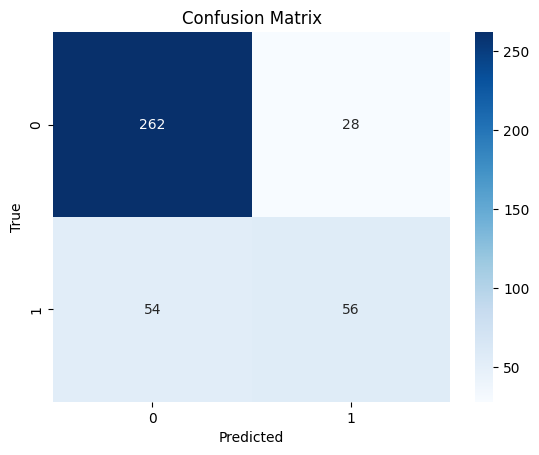

In [36]:
param_grid = {
    "penalty": ["l1", "l2", "elasticnet"],
    "C": [0.01, 0.1, 1, 10, 100],
    "class_weight": [None, "balanced"],
    "solver": ["saga", "lbfgs"],
    "max_iter": [100, 500, 1000],
}
# Best
log_reg = get_best_classifier(
    LogisticRegression(random_state=42),
    scores,
    param_grid,
)
y_lin_pred = log_reg.predict(X_test)
print(classification_report(y_test, y_lin_pred))
confusion_plot(y_test, y_lin_pred)

#### SVM

Fitting 3 folds for each of 576 candidates, totalling 1728 fits
Best params:
{'C': 1, 'class_weight': 'balanced', 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf', 'max_iter': 2000}
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       290
           1       0.48      0.51      0.49       110

    accuracy                           0.71       400
   macro avg       0.64      0.65      0.65       400
weighted avg       0.72      0.71      0.72       400



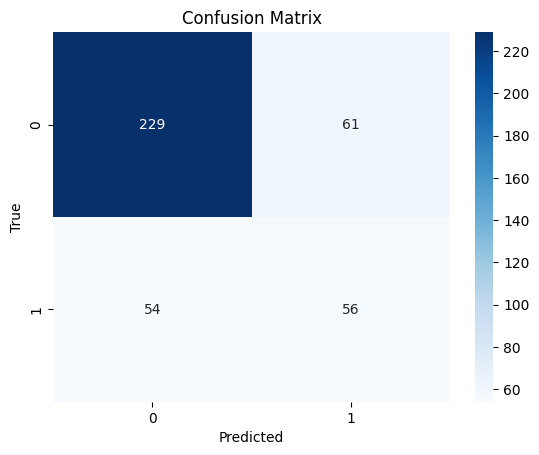

In [38]:
param_grid = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "gamma": ["scale", "auto", 0.1, 0.01],
    "class_weight": ["balanced"],
    "degree": [2, 3, 4],
    "max_iter": [100, 500, 1000, 2000],
}
svc = get_best_classifier(
    SVC(random_state=42),
    scores,
    param_grid,
)
y_svc_pred = svc.predict(X_test)
print(classification_report(y_test, y_svc_pred))
confusion_plot(y_test, y_svc_pred)

#### Random forest

Fitting 3 folds for each of 600 candidates, totalling 1800 fits


C:\Users\maxim\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best params:
{'class_weight': 'balanced_subsample', 'max_depth': 9, 'max_samples': 0.1, 'min_samples_leaf': 2, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       290
           1       0.60      0.58      0.59       110

    accuracy                           0.78       400
   macro avg       0.72      0.72      0.72       400
weighted avg       0.78      0.78      0.78       400



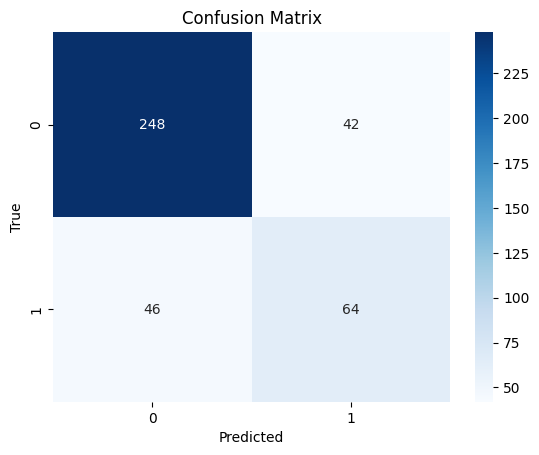

In [39]:
param_grid = {
    "n_estimators": [50, 100, 150],
    "max_depth": [7, 9, 11, 13],
    "min_samples_leaf": [2, 3, 4, 5, 6],
    "max_samples": [0.05, 0.1, 0.15, 0.2, None],
    "class_weight": ["balanced", "balanced_subsample"],
}
rnd_forest = get_best_classifier(
    RandomForestClassifier(n_jobs=-1, random_state=42),
    scores,
    param_grid,
)
y_rnd_pred = rnd_forest.predict(X_test)
print(classification_report(y_test, y_rnd_pred))
confusion_plot(y_test, y_rnd_pred)

#### XGBoost

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best params:
{'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       290
           1       0.65      0.48      0.55       110

    accuracy                           0.79       400
   macro avg       0.73      0.69      0.71       400
weighted avg       0.77      0.79      0.77       400



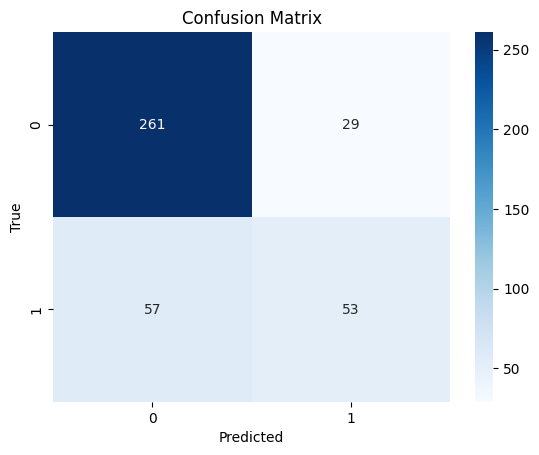

In [40]:
param_grid = {
    "n_estimators": [50, 100, 200, 500],
    "max_depth": [3, 6, 10],
    "learning_rate": [0.01, 0.1, 0.2, 0.3],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}
xgb = get_best_classifier(
    XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss"),
    scores,
    param_grid,
)
y_xgb_pred = xgb.predict(X_test)
print(classification_report(y_test, y_xgb_pred))
confusion_plot(y_test, y_xgb_pred)